# Test of the interaction class   
Aug. 2025

## Description

The interaction class unifies all other classes to calculate scattering problems. Using either a plane wave or a focused beam, this module allows the user to calculate cross-sections and field plots with scatterers of different materials.

## Initialization

A light-matter interaction of the kind that this library aims to tackle is characterized by a beam with certain parameters and a spherical scatterer, also with certain parameters. These are the necessary arguments necessary to instantiate an interaction object - along with a domain.   

This notebook contains a number of examples and demonstrates how to calcualate field plots and cross sections.


In [2]:
from src.interaction import *

In [3]:
# create 3 domain objects of different sizes
domain1 = domain(0.5)
domain2 = domain(1.0)
domain3 = domain(1.5)

## Fields

Let us begin by defining two beams:
* A left circularly polarized LG beam of order $l=3$ with $\lambda=0.5\mu m$ focused with a lens with $NA=0.9$
* A PW with $\lambda=0.3\mu m$ - also left circularly polarized

In [4]:
# define beams
foc1 = focusedBeam(maxJ = 25, wavelength = 0.5, domain = domain1, p = 1, l = 3, NA=0.9)
pw1 = planeWave(wavelength = 0.3, domain = domain1, polarization = "left circular")  

Interaction objects are now defined. We let them interact with the same scatterer: A sphere of radius $0.25\mu m$ and $n_r=4$. Assume the permeabilities to be unity. 
The 'interaction' argument defines which part of the interaction is of interest, and can either be "internal" (fields inside the scatterer), "scattering" (fields outside), or "both".

In [5]:
R = 0.25
nr = 4
# define interaction objects
foc1_interaction = interaction(foc1, domain=domain1, nr=nr, radius=R, interaction="internal")
pw1_interaction = interaction(pw1, domain=domain1, nr=nr, radius=R, interaction="internal")

Both interactions can now be plotted with the plotInt() method.

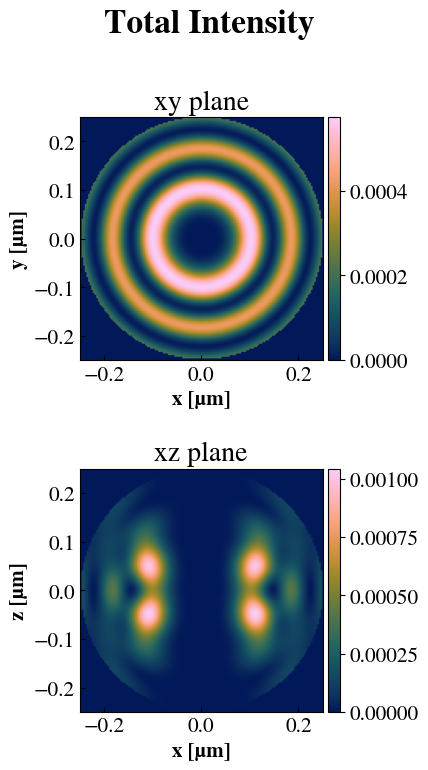

In [6]:
foc1_interaction.plotInt(plot = "total")

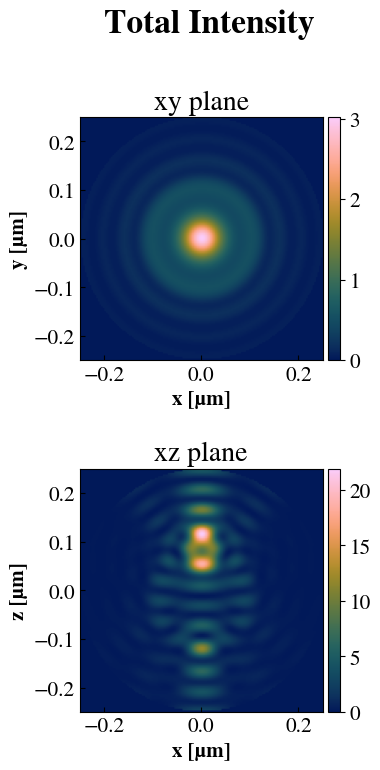

In [7]:
pw1_interaction.plotInt(plot = "total")

Let us look at the scattered fields instead. For this, we define similar objects, but on a larger domain:

In [8]:
foc1_interaction_sc = interaction(foc1, domain=domain3, nr=nr, radius=R, interaction="scattering")
pw1_interaction_sc = interaction(pw1, domain=domain3, nr=nr, radius=R, interaction="scattering")

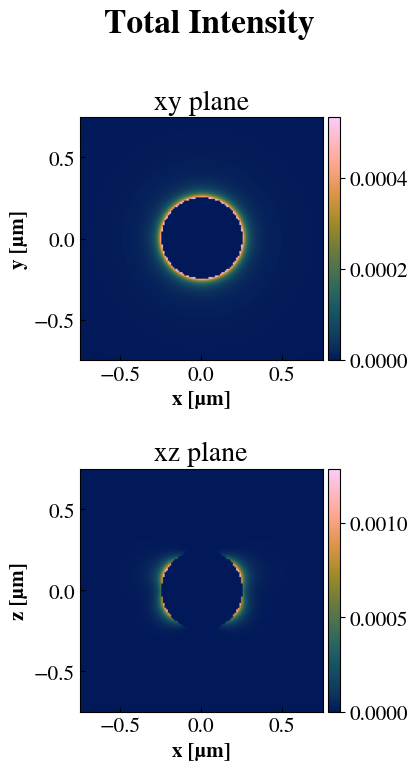

In [9]:
foc1_interaction_sc.plotInt(plot = "total")

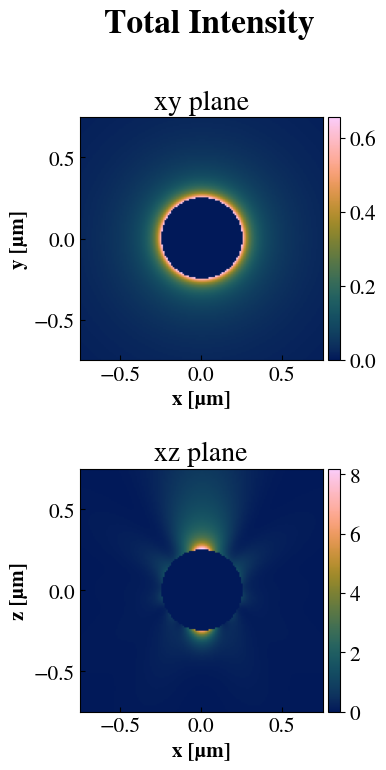

In [10]:
pw1_interaction_sc.plotInt(plot = "total")

To include the incident beam, 'includeBeam' can be set to 'True'. This adds the incident field before the intensity is calculated outside the scatterer (In this formalism, the internal field already includes the incident field). For the focused beam, let us visualize all interactions, this time with the incident field.

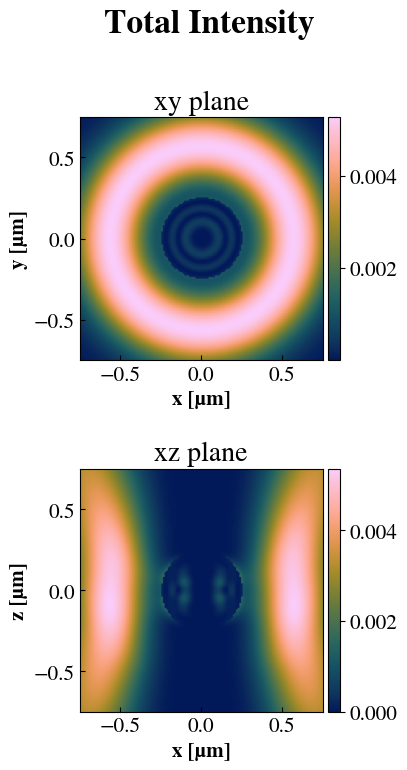

In [11]:
foc1_interaction_both = interaction(foc1, domain=domain3, nr=nr, radius=R, interaction="both")
foc1_interaction_both.plotInt(plot = "total", includeBeam = True)

Here, the coupling between the scatterer and the incident field is evident at the focal point of the lens, where the beam is narrowest.

## Cross sections

Cross sections are often useful to predict the scattering intensities of certain experimental configurations, or to search for resonanses.    
For an instatiated 'interaction' object, the 'getCrossSection()' method is useful.

To begin with, we calculate the single value of the scattering cross section for the PW interaction object. Note that this method will always display the beam and scatterer parameters that are kept constants as sanity checks.

In [12]:
xs = pw1_interaction.getCrossSection(type = "scattering")

-----Constant parameters-----

x = 5.236 

wl = 0.300  µm

radius = 0.250  µm

nr = 4.000 

-----------------------------------------

Cross section has dimension: 0
C_scattering = 0.4304608134078829 µm^2


We can now try the same method with an array of radii. Here, the 'dims' argument can be used. It is not necessary unless one wishes to couple wavelengths and refractive indices together.

-----Constant parameters-----

wl = 0.300 µm

nr = 4.000 

-----------------------------------------

Calculating new size parameter array from radius for 1D cross section with refractive index.



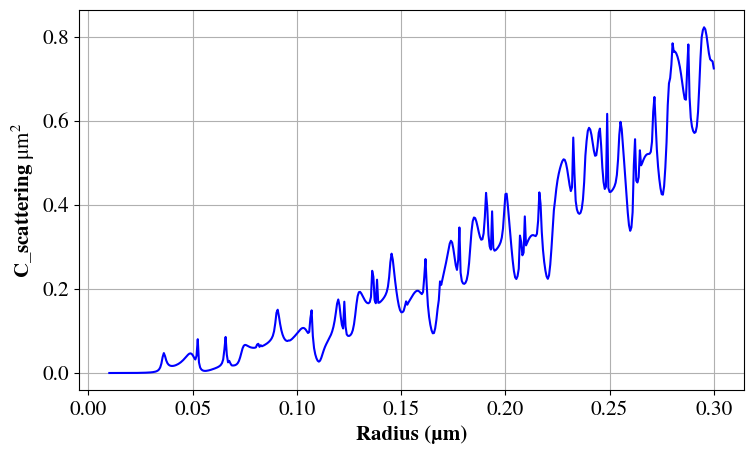

In [13]:
radii = np.linspace(0.01, 0.3, 500)
C = pw1_interaction.getCrossSection(type = "scattering", dims = 1, radius = radii)

Sometimes, it is useful to include the multipolar decomposition of the cross sections. This is allowed through the 'includeParts' argument, producing two additional return values. Without furher ado, this includes all magnetic and electric Mie coefficients up to the specified order of the beam. The plot can be turned off, using 'plot = False'

In [15]:
radii = np.linspace(0.05, 0.25, 200)
xs, m, e = pw1_interaction.getCrossSection(type = "scattering", dims = 1, radius = radii, includeParts = True, plot = False)

-----Constant parameters-----

wl = 0.300 µm

nr = 4.000 

-----------------------------------------

Calculating new size parameter array from radius for 1D cross section with refractive index.



Then one can plot the cross section with the contributions one wishes to include

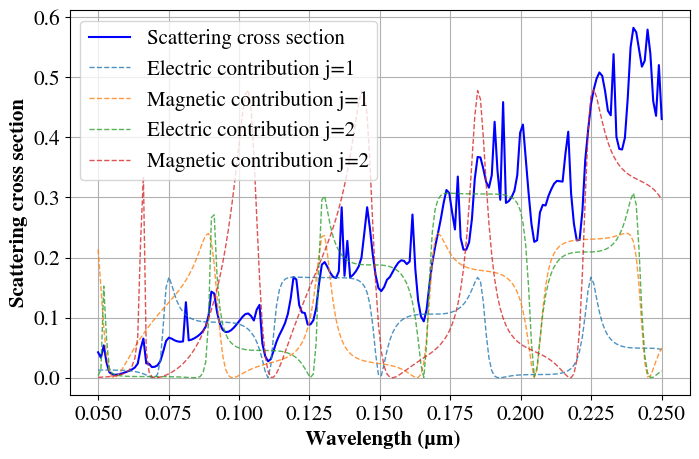

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(radii, xs, linewidth=1.5, color='blue', label=f"Scattering cross section")
for i in range(2):
    plt.plot(radii, e[i], linewidth=1, linestyle='--', alpha=0.8, label = f"Electric contribution j={i+1}")
    plt.plot(radii, m[i], linewidth=1, linestyle='--', alpha=0.8, label = f"Magnetic contribution j={i+1}")
plt.ylabel("Scattering cross section")
plt.xlabel(" Wavelength (µm)")
plt.legend(loc="upper left")
plt.grid(True)

### Silicon test

Let us calculate the scattering cross section of crystalline Silicon, using the data from the "data" folder. 
The parameters used match those from Feng et al. (2017), Phys. Rev. Lett.


In [17]:
from scipy.interpolate import interp1d
import pandas as pd
# import file
df=pd.read_csv("data/nrdata_SI.txt", sep="\t",header=8,decimal='.') # import real part of the complex refractive index n+ik
wl=df.iloc[:, 0]
nr=df.iloc[:, 1] 
wl = wl.to_numpy()
nr = nr.to_numpy()
# Interpolate wl and nr to 500 points
wl_interp = np.linspace(0.4, wl.max(), 500)
nr_interp_func = interp1d(wl, nr, kind='cubic')
nr_interp = nr_interp_func(wl_interp)
wl = wl_interp.copy() 
nr = nr_interp.copy()

In [18]:
R = 0.18 #microns - From paper
# Plane wave interaction
pw = planeWave(wavelength = 0.632, domain = domain1, polarization = "left circular")  
PW_interaction = interaction(pw, domain = domain1, nr= 4, radius=0.18, interaction="both") 

Once again, we extract the magnetic and electric Mie coefficients, disable the plot. We set 'dims=1' explicitly to force a coupled wavelength-nr. This is the default, but can be set to 2 for a wavelength-nr independent calculation

Assuming wavelength dependent refractive index.
-----Constant parameters-----

radius = 0.180  µm

-----------------------------------------

Calculating new size parameter array from wavelength for 1D cross section with refractive index.



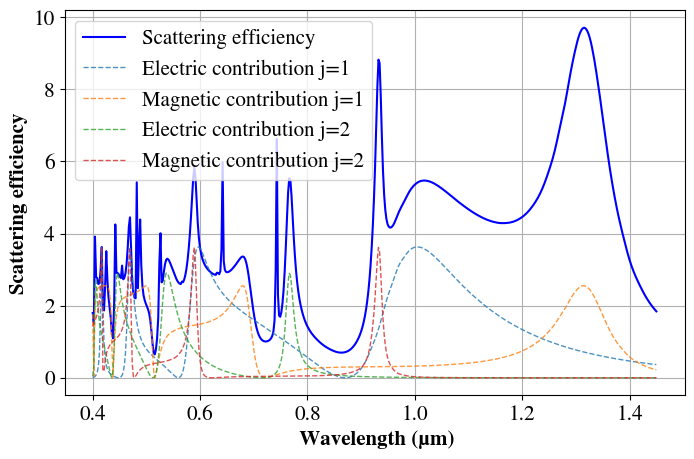

In [19]:
C1, e, m = PW_interaction.getCrossSection(type="scattering", dims=1, radius = R, wavelength = wl, nr = nr, includeParts=True, plot=False)

# plot the scattering efficiencies (cross section normalzed to cross-sectional area of scatterer)

plt.figure(figsize=(8, 5))
plt.plot(wl, C1/(np.pi*R**2), linewidth=1.5, color='blue', label=f"Scattering efficiency")
for i in range(2):
    plt.plot(wl, e[i]/(np.pi*R**2), linewidth=1, linestyle='--', alpha=0.8, label = f"Electric contribution j={i+1}")
    plt.plot(wl, m[i]/(np.pi*R**2), linewidth=1, linestyle='--', alpha=0.8, label = f"Magnetic contribution j={i+1}")
plt.ylabel("Scattering efficiency")
plt.xlabel(" Wavelength (µm)")
plt.legend(loc="upper left")
plt.grid(True)

The cross section from the paper is shown here for comparison. At lower wavelengths, there are peaks shown in the above plot that are not part of the plot below due to the inclusion of fewer multipolar orders in the sum.

<img src="/Users/joakimpugesgaardsandberg/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/DTU/5. år/Student Assistant-Nanomade/Scripts/Git/MieScat/data/Sixs.png" width="340" height="175" style="display: block; margin-left: auto; margin-right: auto;" />

### Water test
We now do a similar treatment of the refractive index of water to validate results from Bohren p. 105 
"Absorption and Scattering of Light by Small Particles". 
Here, we test three scatterers of different radii. We furthermore need to convert the x-axis to inverse size parameter.


In [20]:
import pandas as pd
from scipy.interpolate import interp1d
invwl = np.arange(0.01, 12+0.01, 0.01)  # inverse wavelength in µm^-1
wl = 1/invwl

#load water 
df1 = pd.read_csv("data/nrdata_water.txt", sep="\t", header=8, decimal='.')  # write path to import correctly, import real part of the complex refractive index n+ik
wl_water = df1.iloc[:, 0]
nr_water = df1.iloc[:, 1]
df2 = pd.read_csv("data/ncdata_water.txt", sep="\t", header=8, decimal='.') #  import imaginary part of the complex refractive index n+ik
wl_water_c = df2.iloc[:, 0]
nc_water = df2.iloc[:, 1]

# Interpolate wl and nr to 1000 points
wl_water_interp = 1/invwl
nr_water_interp_func = interp1d(wl_water, nr_water, kind='cubic')
nc_water_interp_func = interp1d(wl_water_c, nc_water, kind='cubic')
nr_water_interp = nr_water_interp_func(wl_water_interp)
nc_water_interp = nc_water_interp_func(wl_water_interp)

wl = wl_water_interp.copy()
nr = nr_water_interp.copy()
nc = nc_water_interp.copy()

#complete complex refractive index
nr = nr + 1j * nc

Assuming wavelength dependent refractive index.
-----Constant parameters-----

radius = 1.000  µm

-----------------------------------------

Calculating new size parameter array from wavelength for 1D cross section with refractive index.

Assuming wavelength dependent refractive index.
-----Constant parameters-----

radius = 0.200  µm

-----------------------------------------

Calculating new size parameter array from wavelength for 1D cross section with refractive index.

Assuming wavelength dependent refractive index.
-----Constant parameters-----

radius = 0.050  µm

-----------------------------------------

Calculating new size parameter array from wavelength for 1D cross section with refractive index.



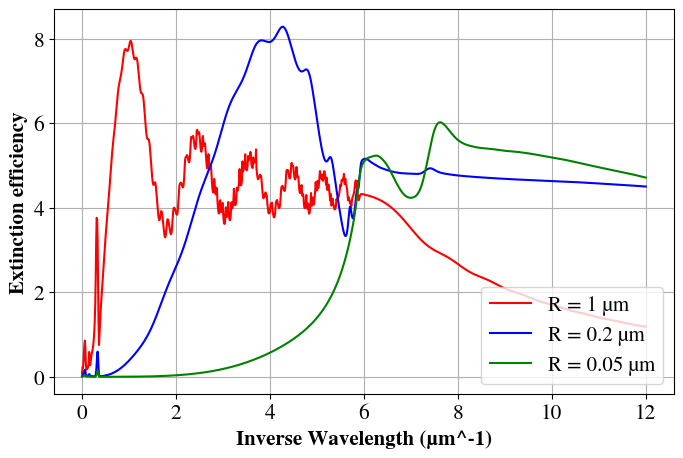

In [21]:

# dims = 1 not set. wl and nr are assumed to be coupled unless otherwise specified
C1, e, m = PW_interaction.getCrossSection(type="extinction", radius = 1, wavelength = wl, nr = nr, includeParts=True, plot=False)
C2, e2, m2 = PW_interaction.getCrossSection(type="extinction", radius = 0.2, wavelength = wl, nr = nr, includeParts=True, plot=False)
C3, e3, m3 = PW_interaction.getCrossSection(type="extinction", radius = 0.05, wavelength = wl, nr = nr, includeParts=True, plot=False)
plt.figure(figsize=(8, 5))
plt.plot(1/wl, C1/(np.pi*1**2), linewidth=1.5, color='red', label=f"R = 1 µm")
plt.plot(1/wl, C2/(np.pi*0.2**2), linewidth=1.5, color='blue', label=f"R = 0.2 µm")
plt.plot(1/wl, C3/(np.pi*0.05**2), linewidth=1.5, color='green', label=f"R = 0.05 µm")
plt.ylabel("Extinction efficiency")
plt.xlabel("Inverse Wavelength (µm^-1)")
plt.legend(loc="lower right")
plt.grid(True)

### 2D   
Cross sections can also be calculated in 2D, as shown below. This takes significantly more time, so think about how many points are included in the arrays.

Here, we analyze the internal cross section of a scatterer of constant size of $1.5\ \mu m$, while varying the wavelength and refractive index.

Assuming independent wavelength and refractive index.
-----Constant parameters-----

radius = 1.500  µm

-----------------------------------------

Calculating new size parameter array from wavelength for 2D cross section with refractive index.



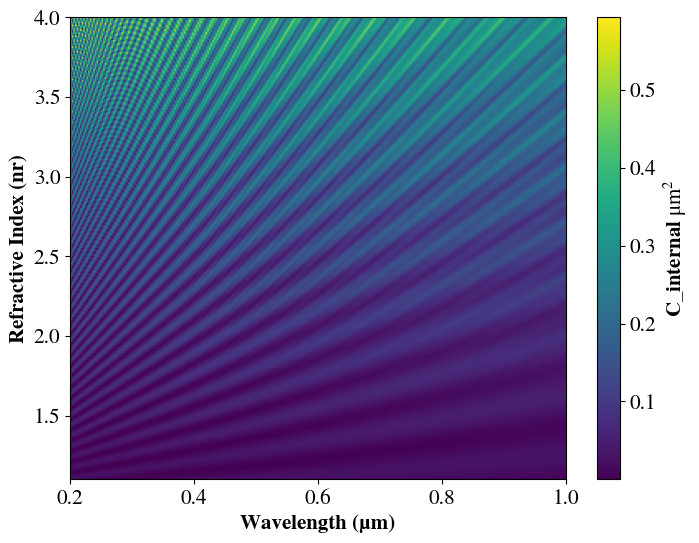

In [22]:
# Calculate internal cross section for a range of refractive indices, wavelengths and a fixed radius
nr = np.linspace(1.1, 4, 300)
wl = np.linspace(0.2, 1, 300) # wavelength not parsed. Uses the one in the object definition

#dims = 2 forces to assume that wavelength and refractive index are independent
Cint = foc1_interaction.getCrossSection(type="internal", dims = 2, nr = nr, wavelength = wl, radius = 1.5, plot = True) # wavelength not parsed. Uses the one in the object definition
